In [1]:
import sys
import pathlib
import pandas as pd
import numpy as np
import boto3

ROOT = pathlib.Path().absolute().parent.as_posix()
if ROOT not in sys.path:
    sys.path.append(ROOT)
    
from helpers import *

In [2]:
client = boto3.client('s3')
bucket=''
file_key = ''
obj = client.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(obj['Body'])

#correct erroneous negative measurements, make positive
df['carbonmonoxide_total_column_corrected'] = abs(df['carbonmonoxide_total_column_corrected'])

In [3]:
df.head()

,carbonmonoxide_total_column_corrected,qa_value,time,layer,latitude,longitude
0,0.029120,0.7,2022-06-01,500.0,51.354122,0.067276
1,0.028327,0.7,2022-06-01,500.0,51.397655,0.026450
2,0.029344,0.7,2022-06-01,500.0,51.279686,-0.321801
3,0.029771,0.7,2022-06-01,500.0,51.441166,-0.014448
4,0.027375,0.7,2022-06-01,500.0,51.323055,-0.362949


<AxesSubplot:>

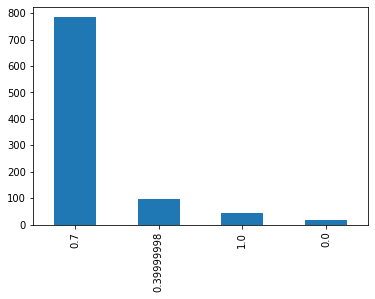

In [4]:
%matplotlib inline
df['qa_value'].value_counts().plot(kind = 'bar')

In [5]:
#problem with temporal variance in data smoothed by setting qa value, a lot of low quality recordings causing a lot of the variational disturbances
#CO has less data points than others so forced to use 0.7 and above
df = df[df['qa_value'] >= 0.7]   #1 for greatest quality measurements (as recommended by Sentinel dataset documentation)

In [6]:
import plotly.express as px

fig = px.scatter_mapbox(df, 
                        lat='latitude', 
                        lon='longitude',
                        color = 'carbonmonoxide_total_column_corrected',
                        center=dict(lat=51.5072, lon=0.1276), zoom=8,
                        mapbox_style="carto-darkmatter",
                        opacity = 0.5,
                        color_continuous_scale=px.colors.sequential.RdBu)

fig.show()

In [7]:
#haversine requires latitude and longitude in radians
import math
df['latitude'] = df['latitude'].apply(math.radians)
df['longitude'] = df['longitude'].apply(math.radians)

In [8]:
!pip3 install tqdm --quiet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['carbonmonoxide_total_column_corrected'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['carbonmonoxide_total_column_corrected'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['carbonmonoxide_total_column_corrected'].ravel()

k_range = range(1, 200)
k_scores = []

#uses 1 data point taken out as validation set with rest used for "training"
cv = LeaveOneOut()

from tqdm import tqdm
for k in tqdm(k_range):
    model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
    loss = abs(cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1))
    k_scores.append(loss.mean())

model.fit(X_train, y_train)

100%|██████████| 199/199 [02:30<00:00,  1.32it/s]


KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=199, weights='distance')

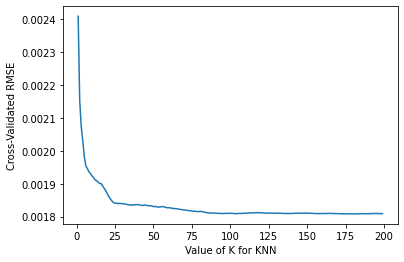

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated RMSE')
plt.show()

In [10]:
y_pred = model.predict(X_test)
results = pd.DataFrame(dtype = 'object')
results['y_test'] = y_test
results['y_pred'] = y_pred
results['difference'] = y_test - y_pred
results['abs_diff'] = abs(y_test - y_pred)
results.head()

,y_test,y_pred,difference,abs_diff
0,0.026490,0.027999,-0.001509,0.001509
1,0.030948,0.027611,0.003336,0.003336
2,0.028605,0.028015,0.000590,0.000590
3,0.028731,0.028148,0.000583,0.000583
4,0.028388,0.027784,0.000603,0.000603


In [11]:
results.describe()

,y_test,y_pred,difference,abs_diff
count,9.000000,9.000000,9.000000,9.000000
mean,0.027376,0.027679,-0.000304,0.001440
std,0.002098,0.000472,0.001917,0.001202
min,0.024361,0.026603,-0.003191,0.000179
25%,0.026490,0.027611,-0.001509,0.000590
50%,0.027185,0.027784,-0.000179,0.000726
75%,0.028605,0.027999,0.000590,0.002242
max,0.030948,0.028148,0.003336,0.003336


<AxesSubplot:>

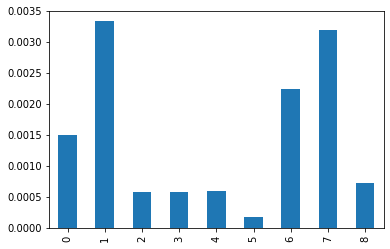

In [12]:
results['abs_diff'].plot.bar()

In [13]:
df['carbonmonoxide_total_column_corrected'].describe()

count    826.000000
mean       0.027735
std        0.002223
min        0.021007
25%        0.026166
50%        0.027751
75%        0.029381
max        0.033807
Name: carbonmonoxide_total_column_corrected, dtype: float64

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['carbonmonoxide_total_column_corrected'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['carbonmonoxide_total_column_corrected'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['carbonmonoxide_total_column_corrected'].ravel()

cv = LeaveOneOut()

parameters = {'n_neighbors': np.arange(start=1, stop=200, step=2)}
grid_search = GridSearchCV(KNeighborsRegressor(weights = 'distance', algorithm = 'brute', metric = 'haversine'), 
                           param_grid = parameters, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs = -1,
                           cv = cv,
                           error_score = 'raise')
grid_search.fit(X_train, y_train)

print('best parameter(s): ', grid_search.best_params_)
print('best score(s): ', grid_search.best_score_)

best parameter(s):  {'n_neighbors': 181}
best score(s):  -0.0018083104385660943


In [15]:
#use all of data in train
X_train = df[['latitude', 'longitude']]
y_train = df['carbonmonoxide_total_column_corrected'].ravel()

#use best k value
k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=181, weights='distance')

In [16]:
#pickle final model locally
import pickle
filename = ROOT + '/Pickles/co_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [17]:
#upload pickle to s3 bucket's pickles folder
upload_pickle_to_s3('', model, '')

Successful upload
